In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Load the data
df_train = pd.read_csv('C:\\Projects\\Kaggle\\playground-series-s5e1\\train.csv')
df_test11 = pd.read_csv('C:\\Projects\\Kaggle\\playground-series-s5e1\\test.csv')


In [5]:
# Check data shapes
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (230130, 6)
Test shape: (98550, 5)


In [6]:
# Handle missing values in num_sold (grouped median imputation)
df_train['num_sold'] = df_train.groupby(['store', 'product'])['num_sold'].transform(lambda x: x.fillna(x.median()))


In [7]:
# Combine train and test for easier feature engineering
df_test['num_sold'] = -1  # Placeholder for test target
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [8]:
# Time-based features
df_combined['date'] = pd.to_datetime(df_combined['date'])
df_combined['day_of_week'] = df_combined['date'].dt.dayofweek
df_combined['month'] = df_combined['date'].dt.month
df_combined['year'] = df_combined['date'].dt.year
df_combined['is_weekend'] = (df_combined['day_of_week'] >= 5).astype(int)

In [9]:
# Create interaction features
df_combined['country_product'] = df_combined['country'] + '_' + df_combined['product']
df_combined['store_product'] = df_combined['store'] + '_' + df_combined['product']


In [10]:
# Define country-specific holiday dates
country_holidays = {
    'Canada': pd.to_datetime(['2010-07-01', '2010-12-25', '2011-07-01', '2011-12-25']),
    'Finland': pd.to_datetime(['2010-06-25', '2010-12-25', '2011-06-24', '2011-12-25']),
    'Italy': pd.to_datetime(['2010-08-15', '2010-12-25', '2011-08-15', '2011-12-25']),
    'Kenya': pd.to_datetime(['2010-12-12', '2010-12-25', '2011-12-12', '2011-12-25']),
    'Norway': pd.to_datetime(['2010-05-17', '2010-12-25', '2011-05-17', '2011-12-25']),
    'Singapore': pd.to_datetime(['2010-08-09', '2010-12-25', '2011-08-09', '2011-12-25'])
}

# Add is_holiday column based on country-specific holiday dates
df_combined['is_holiday'] = 0
for country, holidays in country_holidays.items():
    df_combined.loc[df_combined['country'] == country, 'is_holiday'] = df_combined.loc[
        df_combined['country'] == country, 'date'
    ].isin(holidays).astype(int)


In [13]:
# Lag features
for lag in [7, 30]:
    df_combined[f'lag_{lag}'] = (
        df_combined.groupby(['store', 'product'])['num_sold']
        .shift(lag)
    )

# Rolling mean features
for window in [7, 30]:
    rolling_col = df_combined.groupby(['store', 'product'])['num_sold'].rolling(window, min_periods=1).mean()
    
    # Align rolling result with the original DataFrame
    df_combined[f'rolling_mean_{window}'] = rolling_col.reset_index(level=[0, 1], drop=True)


In [14]:
 #Remove extreme outliers in num_sold (e.g., > 99th percentile)
upper_limit = df_train['num_sold'].quantile(0.99)
df_train = df_train[df_train['num_sold'] <= upper_limit]

# Label encoding for categorical features
le = LabelEncoder()
for col in ['country', 'store', 'product', 'country_product', 'store_product']:
    df_combined[col] = le.fit_transform(df_combined[col])


In [15]:
# Drop unnecessary columns
df_combined = df_combined.drop(['id', 'date'], axis=1)


In [35]:
# Split train and test data
df_train = df_combined[df_combined['num_sold'] != -1]
df_test = df_combined[df_combined['num_sold'] == -1].drop('num_sold', axis=1)

In [36]:
X = df_train.drop('num_sold', axis=1)
y = df_train['num_sold']

In [37]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# LightGBM model parameters
params = {
    'objective': 'regression',
    'metric': 'mape',
    'random_state': 42,
    'learning_rate': 0.01,
    'max_depth': 7,
    'num_leaves': 31,
    'n_estimators': 1000,
    'min_child_samples': 20,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0
}

In [39]:
# Train LightGBM model
model = lgb.LGBMRegressor(**params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='mape'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 14
[LightGBM] [Info] Start training from score 728.956726


LGBMRegressor(learning_rate=0.01, max_depth=7, metric='mape', n_estimators=1000,
              objective='regression', random_state=42, reg_alpha=1.0,
              reg_lambda=1.0)

In [40]:
# Validate model
y_val_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Validation MAPE: {mape * 100:.2f}%")

Validation MAPE: 20.63%


In [41]:
# Predict on test set
test_predictions = model.predict(df_test)




In [44]:


# Use the index from testing_data as the id column in the submission
submission = pd.DataFrame({
    'id':   df_test11['id'],       # Use 'id' column from testing_data
     # Use index from testing_data
    'num_sold': test_predictions    # Predictions from the model
})



# Save the submission file
submission.to_csv('submission123.csv', index=False)
print("Submission file created successfully!")



Submission file created successfully!


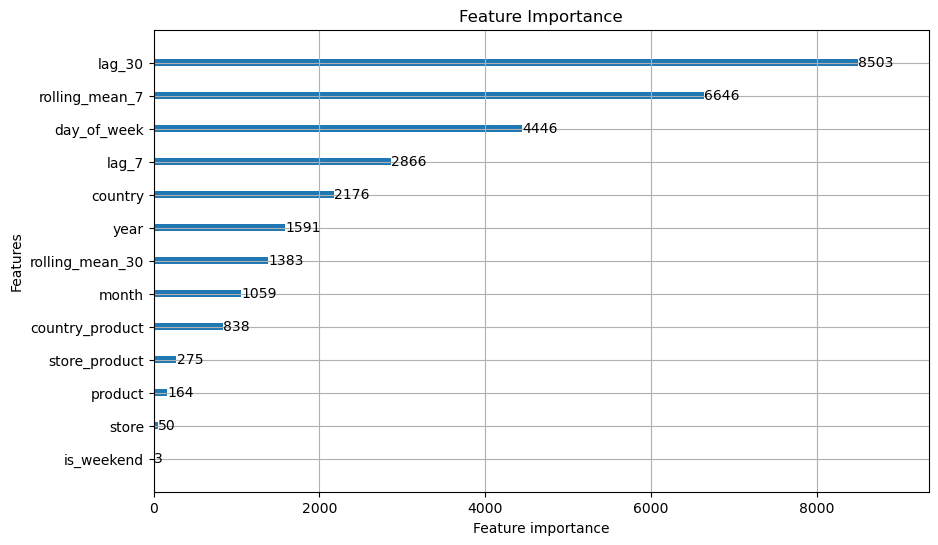

In [45]:

# Plot feature importance
lgb.plot_importance(model, importance_type='split', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()
# Save predictions
#submission = pd.DataFrame({'id': range(len(test_predictions)), 'num_sold': test_predictions})
#submission.to_csv('submission.csv', index=False)
#print("Submission saved!")

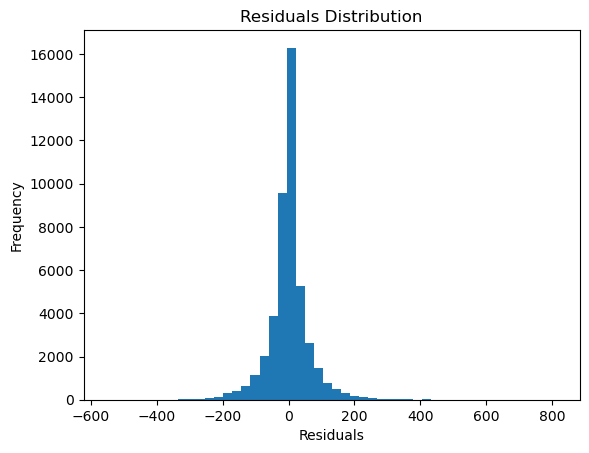

In [46]:
residuals = y_val - model.predict(X_val)

# Plot residuals distribution
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
